In [47]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## Loading MNIST

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9913344it [02:27, 67065.49it/s]


Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw


29696it [00:00, 4331410.89it/s]          


Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw




  0%|          | 0/1648877 [00:00<?, ?it/s]

1649664it [00:31, 51610.32it/s]                             
5120it [00:00, 25998591.38it/s]         

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw




/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [24]:
class Discriminator(torch.nn.Module):
    """Discriminator Model

    Loss is BCE

    :param torch: [description]
    :type torch: [type]
    """
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = torch.nn.Linear(784, 256)
        self.fc2 = torch.nn.Linear(256, 256)
        self.fc3 = torch.nn.Linear(256, 1)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return self.sigmoid(x)

In [76]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = torch.nn.Linear(100, 256)
        self.fc2 = torch.nn.Linear(256, 256)
        self.fc3 = torch.nn.Linear(256, 784)
        self.lrelu = torch.nn.ReLU()

    def forward(self, x):
        x = self.lrelu(self.fc1(x))
        x = self.lrelu(self.fc2(x))
        x = self.fc3(x)
        return x

In [102]:
criterion = torch.nn.BCELoss()
D = Discriminator()
G = Generator()

In [103]:
optim_G = torch.optim.Adam(G.parameters(), lr=0.0002)
optim_D = torch.optim.Adam(D.parameters(), lr=0.0002)

In [104]:
random_sample = torch.rand(1, 100)

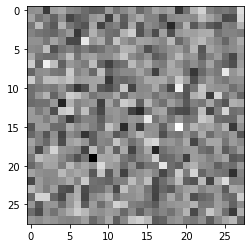

In [105]:
plt.imshow(G(random_sample).view(28, 28).detach().numpy(), cmap='gray')

## Training

1. Generate Fake Images
2. Feed to discriminator
3. Get generator loss and train generator
4. Generate more fake images
5. Feed to discriminator
6. Get discriminator loss and train discriminator

In [106]:
EPOCHS = 35
REAL_LABEL = 1.0
FAKE_LABEL = 0.0

In [107]:
for epoch in range(1, EPOCHS + 1):
    loss_d = 0.0
    loss_g = 0.0
    for images, labels in tqdm(trainloader):
        fake_labels = torch.full((images.size(0), 1), FAKE_LABEL)
        real_labels = torch.full((images.size(0), 1), REAL_LABEL)
        ### Training Discriminator ###
        ### Maximize log(D(x)) + log(1 - D(G(z))) ###
        optim_D.zero_grad()

        noise = torch.randn(images.size(0), 100)
        fake_images = G(noise)
        d_real = D(images)
        d_fake = D(fake_images)

        # d_loss = criterion(d_real, torch.ones(d_real.size())) + criterion(d_fake, torch.zeros(d_fake.size())) # loss_fake + loss_real
        d_loss_real = criterion(d_real, real_labels)
        d_loss_fake = criterion(d_fake, fake_labels)
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optim_D.step()
        loss_d += d_loss

        ### Training Generator ###
        ### Maximize log(D(G(z))) ###
        optim_G.zero_grad()
        noise = torch.randn(images.size(0), 100)
        fake_images = G(noise)
        d_fake = D(fake_images)
        g_loss = criterion(d_fake, real_labels)
        g_loss.backward()
        loss_g += g_loss
        optim_G.step()
    
    print('Epoch [{}/{}], Loss_D: {:.4f}, Loss_G: {:.4f}'.format(epoch, EPOCHS, loss_d / len(trainloader), loss_g / len(trainloader)))

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [1/35], Loss_D: 0.3765, Loss_G: 3.0167


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [2/35], Loss_D: 0.9863, Loss_G: 2.9274


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [3/35], Loss_D: 0.7994, Loss_G: 1.9590


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [4/35], Loss_D: 0.9786, Loss_G: 2.4117


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [5/35], Loss_D: 1.1245, Loss_G: 1.7591


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [6/35], Loss_D: 1.0838, Loss_G: 1.4808


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [7/35], Loss_D: 0.8752, Loss_G: 1.6926


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [8/35], Loss_D: 0.9880, Loss_G: 1.9183


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [9/35], Loss_D: 0.6399, Loss_G: 2.1340


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [10/35], Loss_D: 0.5443, Loss_G: 2.3943


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [11/35], Loss_D: 0.5784, Loss_G: 2.7131


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [12/35], Loss_D: 0.6921, Loss_G: 2.5493


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [13/35], Loss_D: 0.7577, Loss_G: 2.3828


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [14/35], Loss_D: 0.6998, Loss_G: 2.2063


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [15/35], Loss_D: 0.6163, Loss_G: 2.3092


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [16/35], Loss_D: 0.5971, Loss_G: 2.4648


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [17/35], Loss_D: 0.6133, Loss_G: 2.3743


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [18/35], Loss_D: 0.6692, Loss_G: 2.4149


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [19/35], Loss_D: 0.7016, Loss_G: 2.2532


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [20/35], Loss_D: 0.8157, Loss_G: 2.2394


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [21/35], Loss_D: 0.8516, Loss_G: 2.0363


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [22/35], Loss_D: 0.8746, Loss_G: 1.8538


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [23/35], Loss_D: 0.8831, Loss_G: 1.7683


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [24/35], Loss_D: 0.8005, Loss_G: 1.7757


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [25/35], Loss_D: 0.8545, Loss_G: 1.9139


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [26/35], Loss_D: 0.9117, Loss_G: 1.7429


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [27/35], Loss_D: 0.9376, Loss_G: 1.8302


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [28/35], Loss_D: 0.9469, Loss_G: 1.7322


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [29/35], Loss_D: 0.9784, Loss_G: 1.7418


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [30/35], Loss_D: 1.0223, Loss_G: 2.0703


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [31/35], Loss_D: 0.9931, Loss_G: 1.9527


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [32/35], Loss_D: 1.0120, Loss_G: 1.7579


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [33/35], Loss_D: 0.9896, Loss_G: 1.6564


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [34/35], Loss_D: 1.0153, Loss_G: 1.5958


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [35/35], Loss_D: 0.9540, Loss_G: 1.7789


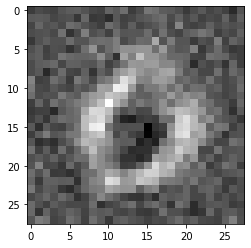

In [121]:
random_sample = torch.rand(1, 100)
plt.imshow(G(random_sample).view(28, 28).detach().numpy(), cmap='gray')